In [299]:
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import torch.nn as nn

torch.manual_seed(2147483647)


In [300]:
names = pd.read_csv("names.txt",names = ["label"])
names.label[:5]

0        emma
1      olivia
2         ava
3    isabella
4      sophia
Name: label, dtype: object

#### create Dataset

In [301]:
blocks = 3 # Number of blocks to pad the words
all_stoi = {} # Character to index mapping
all_itos ={} # Index to character mapping

def create_dataset(names):

    all = set("".join(names.label+"."))
    for index,(chr) in enumerate(sorted(all)):
        all_stoi[chr] = index

    for index,(chr) in enumerate(sorted(all)):
        all_itos[index] = chr


    x= []
    y = []
    for word in names.label:
        wx = [("."* (blocks - i)) + word  for i in range(blocks)]
        wy = [y.append(all_stoi[i]) for i in (word+".")]
                        
        for ch1,ch2,ch3 in zip(*wx[:len(wx)]):
            x.append((all_stoi[ch1],all_stoi[ch2],all_stoi[ch3]))



    x = torch.tensor(x)
    y = torch.tensor(y)

    return x, y

# Create train and test datasets
x, y = create_dataset(names)

train_x,val_x,train_y,val_y = train_test_split(x,y,test_size=0.2,shuffle=True,stratify = y,random_state=42)
val_x,test_x,val_y,test_y = train_test_split(val_x,val_y,test_size=0.1,stratify = val_y, random_state=42)

# print(f"train_x: {train_x.shape} train_y: {train_y.shape}") 
# print(f"val_x: {val_x.shape} val_y: {val_y.shape}")
# print(f"test_x: {test_x.shape} test_y: {test_y.shape}")

# Output:
# train_x: torch.Size([182516, 3]) train_y: torch.Size([182516])
# val_x: torch.Size([41067, 3]) val_y: torch.Size([41067])
# test_x: torch.Size([4563, 3]) test_y: torch.Size([4563])

#### format

In [302]:
## Make a pytorchfying code

# class MLPai:
#     def __init__(self,fan_in,fan_out,bias=True):
#         self.weight = torch.randn(fan_in,fan_out) /fan_in ** 0.05 # this is square root of fan in ,(kaiming technique)
#         self.bias = torch.zeros(fan_out) if bias else None

#         self.all_layer = torch.nn.Sequential(
#             torch.nn.Linear(x,fan_out),
#             batch_norm
#             nn.Tanh(),

#             torch.nn.Linear(fan_out,fan_out),
#             nn.Tanh(),

#             torch.nn.Linear(fan_out,27),
#         )

#     def 


class Linear:
    def __init__(self,fan_in,fan_out,bias = True):
        self.weights = torch.randn(fan_in,fan_out) # / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None 

    def __call__(self,x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias 
        return self.out

    def parameter(self):
        return [self.weights] + [self.bias] if self.bias is not None else []


class BatchNorm1d:
    def __init__(self,dim,epsilion=1e-5,momentum = 0.1,training=True):
        self.epsilion = epsilion
        self.momentum = momentum

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

        self.training = training

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0,keepdim = True) # each one batch have calculate mean of that inside content
            xstd = x.std(0,keepdim = True) # each one batch have calculate std of that inside content
        else:
            xmean = self.running_mean 
            xstd = self.running_std 

        xhat = (x-xmean) / (torch.sqrt(xstd + self.epsilion))
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xstd

        return self.out
    

    def parameter(self):
        return [self.gamma,self.beta] 


class Tanh:
    def __call__(self,x):
        self.out= torch.tanh(x)
        self.out.retain_grad()  

        return self.out
    def parameter(self):
        return [] 


n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
vocab_size = len(all_itos)
lr = 0.001

C = torch.randn(vocab_size, n_embd)


# layers = [
#   Linear(n_embd * blocks, n_hidden, bias=True), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=True),  Tanh(),
#   Linear(           n_hidden, n_hidden, bias=True),  Tanh(),
#   Linear(           n_hidden, n_hidden, bias=True),  Tanh(),
#   Linear(           n_hidden, n_hidden, bias=True),  Tanh(),
#   Linear(           n_hidden, vocab_size, bias=True),
# ]

layers = [
  Linear(n_embd * blocks, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
#   layers[-1].weights *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weights *=1.0 #5/3 #5/3    
      
for layer in layers:
    for p in layer.parameter():
        print(p.shape)

parameters = [C] + [p for layer in layers for p in layer.parameter()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([27])
torch.Size([27])
1324


In [303]:
# same optimization as last time
Epochs = 50000 + 50000

optimizer = torch.optim.SGD(parameters,lr = lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max = Epochs)
batch_size = 32
lossi = []
ud = []


for epoch in range(Epochs):

    batching = torch.randint(0 ,train_x.shape[0],(batch_size,))
    tx,ty = train_x[batching],train_y[batching]
    
    # forward pass
    embedding = C[tx] # embed the characters into vectors
    x = embedding.view(embedding.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, ty) # loss function
    loss



    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
     
    # Track Stats
    if epoch % 10000 == 0:
        print(f"Epoch: {epoch} || loss: {loss.item()} ")
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([((lr*p.grad).std()/ p.data.std()).log10().item() for p in parameters])
    
    if epoch >= 1000:
        break




Epoch: 0 || loss: 3.3543975353240967 


Layer: 2 mean: 0.00 std: 0.82  saturated: 36.56%
Layer: 5 mean: 0.00 std: 0.86  saturated: 47.78%
Layer: 8 mean: -0.01 std: 0.87  saturated: 50.75%
Layer: 11 mean: -0.00 std: 0.86  saturated: 47.00%
Layer: 14 mean: 0.01 std: 0.86  saturated: 48.31%


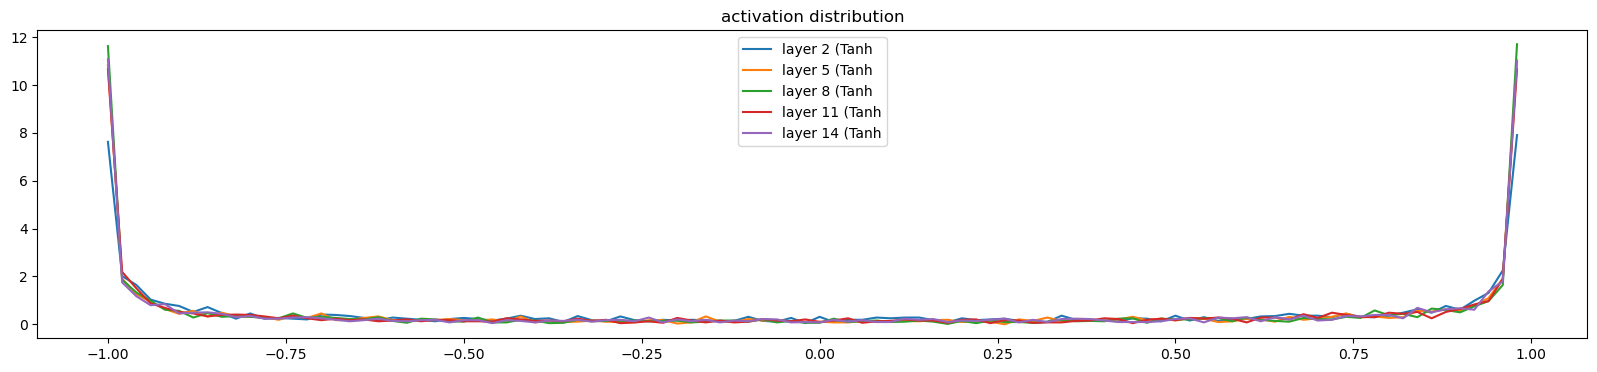

In [304]:
plt.figure(figsize=(20,4))

legends = []

# plt.legend(legnds)
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t = layer.out
        print(f"Layer: {i} mean: {t.mean():.2f} std: {t.std():.2f}  saturated: {(t.abs() >0.97).float().mean()*100:.2f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')
plt.show()

Layer: 2 mean: -2.444721682037798e-11 std: 0.0035284191835671663
Layer: 5 mean: 5.238689690378884e-12 std: 0.0022923254873603582
Layer: 8 mean: 2.328306384496992e-12 std: 0.0017464924603700638
Layer: 11 mean: 6.984919153490976e-12 std: 0.0010959528153762221
Layer: 14 mean: 0.0 std: 0.0007496898178942502


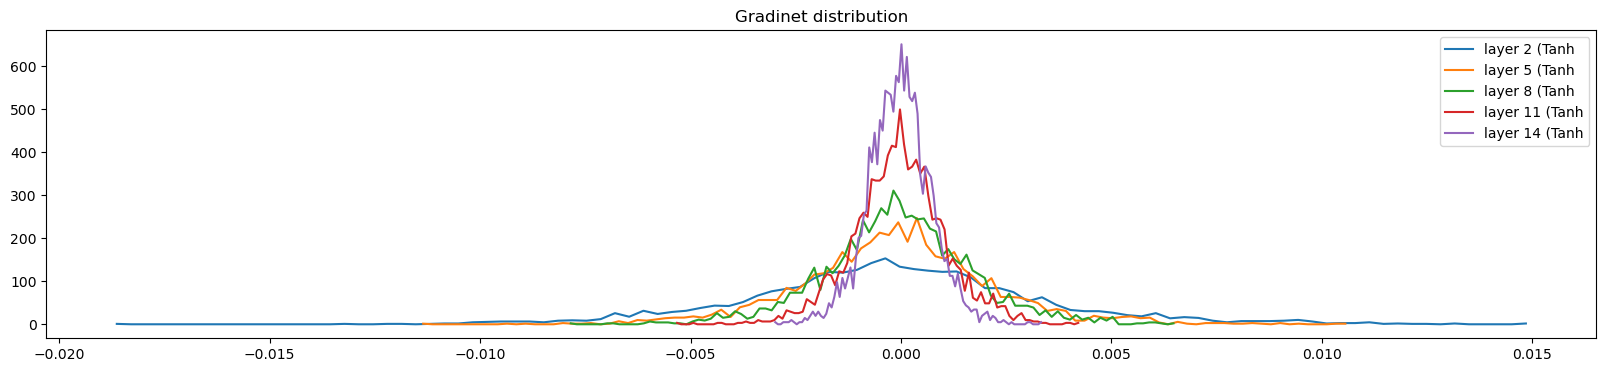

In [305]:
plt.figure(figsize=(20,4))

legends = []

# plt.legend(legnds)
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t = layer.out.grad
        print(f"Layer: {i} mean: {t.mean()} std: {t.std()}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('Gradinet distribution')
plt.show()

Layer: torch.Size([27, 10]) |  mean: -3.0354216362660225e-10 | std: 0.013335142284631729 | grad ratio: 0.013325484469532967


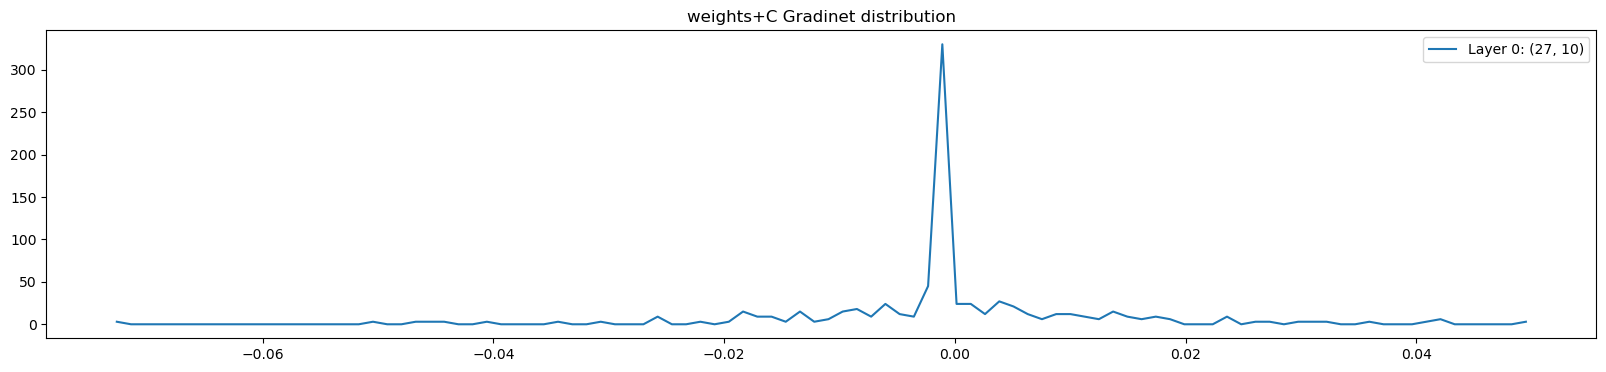

In [306]:
plt.figure(figsize=(20,4))
legends = []
# plt.legend(legnds)
for i,p in enumerate(parameters):
        t = p.grad
        if p.ndim == 2:
                print(f"Layer: {t.shape} |  mean: {t.mean()} | std: {t.std()} | grad ratio: {t.std()/p.std()}")
                hy, hx = torch.histogram(t, density=True)
                plt.plot(hx[:-1].detach(), hy.detach())
                legends.append(f"Layer {i}: {t.shape[0],t.shape[1]}")
plt.legend(legends)
plt.title('weights+C Gradinet distribution')
plt.show()

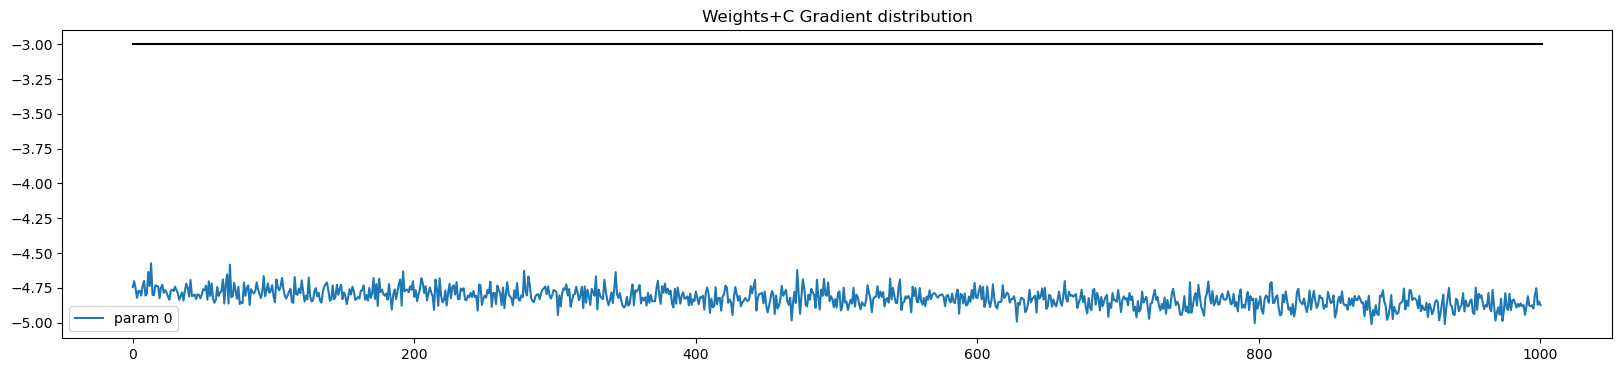

In [307]:
plt.figure(figsize=(20,4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f"param {i}")

plt.plot([0, len(ud)], [-3, -3], 'k')  # Fixed: len(ud) not len[ud]
plt.legend(legends)
plt.title('Weights+C Gradient distribution')  # Fixed: Gradinet -> Gradient
plt.show()
